<a href="https://colab.research.google.com/github/khailcon/Huehueteotl/blob/Alec_Code/Ceramic_Project_CHEM599.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Huehueteotl Ceramic Analysis Project

** https://github.com/khailcon/Huehueteotl **

##Tasks to accomplish
* Edge Detection of ceramics
* Void Detection via inverting color scheme
* Shape Detection
* Automation or For looping for a folder of images
* Share an online folder for raw data that we can access using code
* Make a yml

 

In [2]:
#import all necessary packages
import matplotlib.pyplot as plt
from math import sqrt
import skimage as sk
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, canny
from skimage.filters import rank
from skimage.morphology import disk, square, binary_dilation, binary_erosion
from skimage.segmentation import watershed
from skimage.util import img_as_float, img_as_ubyte, invert
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu, sobel
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects
# turn on if using colab
# from google.colab import drive
from pathlib import Path
import colorthief
import pandas as pd
import numpy as np
import numpy.ma as ma #masking
from time import sleep
from PIL import Image
from colorthief import ColorThief
#from tqdm import tqdm



In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:

def inclusion_counter(image, blob_algorithm = 'doh', max_sigma = 30, threshold = 0.1):
    image_gray = rgb2gray(image)
    if blob_algorithm == 'doh':
        blobs = blob_doh(image_gray, max_sigma = max_sigma, threshold = threshold)
        inclusions = len(blobs)
    elif blob_algorithm == 'dog':
        blobs = blob_dog(image_gray, max_sigma = max_sigma, threshold = threshold)
        blobs[:,2] = blobs[:, 2] * sqrt(2)
        inclusions = len(blobs)
    elif blob_algorithm == 'log':
        blobs = blob_log(image_gray, max_sigma = max_sigma, num_sigma = 10, threshold = threshold)
        blobs[:,2] = blobs[:, 2] * sqrt(2)
        inclusions = len(blobs)
    elif blob_algorithm == 'all':
        blobs_doh = blob_doh(image_gray, max_sigma = max_sigma, threshold = .1*threshold)
        blobs_dog = blob_dog(image_gray, max_sigma = max_sigma, threshold = threshold)
        blobs_dog[:,2] = blobs_dog[:, 2] * sqrt(2)
        blobs_log = blob_log(image_gray, max_sigma = max_sigma, num_sigma = 10, threshold = threshold)
        blobs_log[:,2] = blobs_log[:, 2] * sqrt(2)
        inclusions = ((len(blobs_doh)+len(blobs_dog)+len(blobs_log))/3)
    return inclusions

    """This function returns a rough count of the number of inclusions based on various algorithms for a folder of ceramic scans

  Parameters
  -----------
  folder_path : the path of a local folder with images ending in _int.jpeg starting from 1 to n
  blob_algorithm : str, optional
    Default: 'all'. ('dog': Difference of Gaussian, 'log': Laplacian of Gaussian, 'doh': Determinant of Hessian, 'region': runs a region isolation to identify inclusions, 'all': Average of all three blob algorithms and region detection)
    note- if 'all', threshold for doh will be one magnitude smaller
  max_sigma : float, optional
    Keep this high to detect large blobs
    Corresponds to anticipated maximum blob size in pixel radius
  threshold : float, optional
    Reduce this to detect less prominent blobs

  Returns
  --------
  DataFrame
    Summary statistics for each ceramic's inclusions
  """



In [130]:
def inclusion_counter2(folder_path, blob_algorithm = 'all', max_sigma = 30, threshold = 0.4, scan_dpi = 600):
    threshold_doh = threshold/40
    dpcm = (scan_dpi/.3937)**2
    path_strs = [str(path) for path in (Path(folder_path).rglob('*.jpeg'))]
     # because path is object not string


    #image operations
    maxrad = []
    meanrad = []
    minrad = []
    inclusions = []
    std = []
    pct_25 = []
    pct_75 = []
    maxrad_reg = []
    meanrad_reg = []
    minrad_reg = []
    inclusions_reg = []
    std_reg = []
    pct_25_reg = []
    pct_75_reg = []
    names = []
    area = []
    maxrad_doh = []
    meanrad_doh = []
    minrad_doh = []
    inclusions_doh = []
    std_doh = []
    pct_25_doh = []
    pct_75_doh = []
    maxrad_dog = []
    meanrad_dog = []
    minrad_dog = []
    inclusions_dog = []
    std_dog = []
    pct_25_dog = []
    pct_75_dog = []
    maxrad_log = []
    meanrad_log = []
    minrad_log = []
    inclusions_log = []
    std_log = []
    pct_25_log = []
    pct_75_log = []
    
    data = pd.DataFrame()

    if blob_algorithm == 'doh':
        for path in path_strs:
            name = path
            names.append(name.rsplit(sep = '/')[-1]) #need to get a column in there with names from each ceramic might need to be part of top chunk
            im = plt.imread(name)
            image_gray = rgb2gray(im)
            blobs_doh = blob_doh(image_gray, max_sigma = max_sigma, threshold = threshold_doh)
            inclusions.append(len(blobs_doh))
            maxrad.append(np.max(blobs_doh[:,2]))
            meanrad.append(blobs_doh[:,2].mean())
            minrad.append(blobs_doh[:,2].min())
            std.append(np.std(blobs_doh[:,2]))
            pct_25.append(np.percentile(blobs_doh[:,2], 25))
            pct_75.append(np.percentile(blobs_doh[:,2], 75))
            imcan = canny(rgb2gray(im))
            sherd_bi = binary_fill_holes(binary_erosion(binary_dilation(imcan, disk(10)), disk(10)))
            sherd_bi = remove_small_objects(sherd_bi, 200)
            object_labels = label((sherd_bi))
            regions = regionprops_table(object_labels, properties = ['area'])
            tempdf = pd.DataFrame(regions)
            area.append(np.max(regions['area'])/dpcm)        
        data['Name']= names 
        data['Maximum Inclusion Radius'] = maxrad
        data['Average Inclusion Radius'] = meanrad
        data['Minimum Inclusion Radius'] = minrad
        data['Estimated Total Inclusions']= inclusions
        data['Standard Deviation'] = std
        data['25th Percentile'] = pct_25
        data['75th Percentile'] = pct_75
        data['Sherd Area sq cm'] = area
        data['Inclusions/ Sherd Area']= data['Estimated Total Inclusions']/data['Sherd Area sq in']
            
    elif blob_algorithm == 'dog':
        for path in path_strs:
            name = path
            names.append(name.rsplit(sep = '/')[-1]) #need to get a column in there with names from each ceramic might need to be part of top chunk
            im = plt.imread(name)
            image_gray = rgb2gray(im)
            blobs_dog = blob_dog(image_gray, max_sigma = max_sigma, threshold = threshold)
            inclusions.append(len(blobs_dog))
            maxrad.append(blobs_dog[:,2].max())
            meanrad.append(blobs_dog[:,2].mean())
            minrad.append(blobs_dog[:,2].min())
            std.append(np.std(blobs_dog[:,2]))
            pct_25.append(np.percentile(blobs_dog[:,2], 25))
            pct_75.append(np.percentile(blobs_dog[:,2], 75))
            imcan = canny(rgb2gray(im))
            sherd_bi = binary_fill_holes(binary_erosion(binary_dilation(imcan, disk(10)), disk(10)))
            sherd_bi = remove_small_objects(sherd_bi, 200)
            object_labels = label((sherd_bi))
            regions = regionprops_table(object_labels, properties = ['area'])
            tempdf = pd.DataFrame(regions)
            area.append(np.max(regions['area'])/dpcm)      
        data['Name']= names 
        data['Maximum Inclusion Radius'] = maxrad
        data['Average Inclusion Radius'] = meanrad
        data['Minimum Inclusion Radius'] = minrad
        data['Estimated Total Inclusions']= inclusions
        data['Standard Deviation'] = std
        data['25th Percentile'] = pct_25
        data['75th Percentile'] = pct_75
        data['Sherd Area sq cm'] = area
        data['Inclusions/ Sherd Area']= data['Estimated Total Inclusions']/data['Sherd Area sq cm']
            

    elif blob_algorithm == 'log':
        for path in path_strs:
            name = path
            names.append(name.rsplit(sep = '/')[-1]) #need to get a column in there with names from each ceramic might need to be part of top chunk
            im = plt.imread(name)
            image_gray = rgb2gray(im)
            blobs_log = blob_log(image_gray, max_sigma = max_sigma, num_sigma = 10, threshold = threshold)
            blobs_log[:,2] = blobs_log[:, 2] * sqrt(2)
            inclusions.append(len(blobs_log))
            maxrad.append(blobs_log[:,2].max())
            meanrad.append(blobs_log[:,2].mean())
            minrad.append(blobs_log[:,2].min())
            std.append(np.std(blobs_log[:,2]))
            pct_25.append(np.percentile(blobs_log[:,2], 25))
            pct_75.append(np.percentile(blobs_log[:,2], 75))
            imcan = canny(rgb2gray(im))
            sherd_bi = binary_fill_holes(binary_erosion(binary_dilation(imcan, disk(10)), disk(10)))
            sherd_bi = remove_small_objects(sherd_bi, 200)
            object_labels = label((sherd_bi))
            regions = regionprops_table(object_labels, properties = ['area'])
            area.append(regions['area'].max()/dpcm)       
        data['Name']= names 
        data['Maximum Inclusion Radius'] = maxrad
        data['Average Inclusion Radius'] = meanrad
        data['Minimum Inclusion Radius'] = minrad
        data['Estimated Total Inclusions']= inclusions
        data['Standard Deviation'] = std
        data['25th Percentile'] = pct_25
        data['75th Percentile'] = pct_75
        data['Sherd Area sq in'] = area
        data['Inclusions/ Sherd Area']= data['Estimated Total Inclusions']/data['Sherd Area sq cm']
   

    if blob_algorithm == 'region':
        for path in path_strs:
            name = path
            names.append(name.rsplit(sep = '/')[-1]) #need to get a column in there with names from each ceramic might need to be part of top chunk
            im = plt.imread(name)
            image_gray = rgb2gray(im)
            thresholda = threshold_otsu(image_gray)
            mask = image_gray > thresholda
            object_labels = label(mask)
            regions = regionprops_table(object_labels, properties = ['area', 'eccentricity', 'major_axis_length', 'orientation'])
            df = pd.DataFrame(regions)
            df = df[df['area'] > 3]
            inclusions.append(len(df))
            maxrad.append(np.sort(df['major_axis_length'])[-2])
            meanrad.append(np.mean(df['major_axis_length']))
            minrad.append(np.min(df['major_axis_length']))
            std.append(np.std(df['major_axis_length']))
            pct_25.append(np.percentile(df['major_axis_length'], 25))
            pct_75.append(np.percentile(df['major_axis_length'], 75))
            area.append(regions['area'].max()/dpcm)       
        data['Name']= names 
        data['Maximum Inclusion Radius'] = maxrad
        data['Average Inclusion Radius'] = meanrad
        data['Minimum Inclusion Radius'] = minrad
        data['Estimated Total Inclusions']= inclusions
        data['Standard Deviation'] = std
        data['25th Percentile'] = pct_25
        data['75th Percentile'] = pct_75
        data['Sherd Area sq cm'] = area
        data['Inclusions/ Sherd Area']= data['Estimated Total Inclusions']/data['Sherd Area sq cm']
        
 
    elif blob_algorithm == 'all':
        for path in path_strs:
            name = path
            names.append(name.rsplit(sep = '/')[-1]) #need to get a column in there with names from each ceramic might need to be part of top chunk
            im = plt.imread(name)
            image_gray = rgb2gray(im)
            blobs_doh = blob_doh(image_gray, max_sigma = max_sigma, threshold = threshold_doh)
            blobs_dog = blob_dog(image_gray, max_sigma = max_sigma, threshold = threshold)
            blobs_dog[:,2] = blobs_dog[:, 2] * sqrt(2)
            blobs_log = blob_log(image_gray, max_sigma = max_sigma, num_sigma = 10, threshold = threshold)
            blobs_log[:,2] = blobs_log[:, 2] * sqrt(2)
            thresholda = threshold_otsu(image_gray)
            mask = image_gray > thresholda
            object_labels = label(mask)
            regions = regionprops_table(object_labels, properties = ['area', 'eccentricity', 'major_axis_length', 'orientation'])
            df = pd.DataFrame(regions)
            df = df[df['area'] > 3]
            inclusions_reg.append(len(df))
            maxrad_reg.append(np.sort(df['major_axis_length'])[-2])
            meanrad_reg.append(np.mean(df['major_axis_length']))
            minrad_reg.append(np.min(df['major_axis_length']))
            std_reg.append(np.std(df['major_axis_length']))
            pct_25_reg.append(np.percentile(df['major_axis_length'], 25))
            pct_75_reg.append(np.percentile(df['major_axis_length'], 75)) 
            inclusions_doh.append(len(blobs_doh))
            maxrad_doh.append(np.max(blobs_doh[:,2]))
            meanrad_doh.append(blobs_doh[:,2].mean())
            minrad_doh.append(blobs_doh[:,2].min())
            std_doh.append(np.std(blobs_doh[:,2]))
            pct_25_doh.append(np.percentile(blobs_doh[:,2], 25))
            pct_75_doh.append(np.percentile(blobs_doh[:,2], 75))
            inclusions_dog.append(len(blobs_dog))
            maxrad_dog.append(blobs_dog[:,2].max())
            meanrad_dog.append(blobs_dog[:,2].mean())
            minrad_dog.append(blobs_dog[:,2].min())
            std_dog.append(np.std(blobs_dog[:,2]))
            pct_25_dog.append(np.percentile(blobs_dog[:,2], 25))
            pct_75_dog.append(np.percentile(blobs_dog[:,2], 75))
            inclusions_log.append(len(blobs_log))
            maxrad_log.append(blobs_log[:,2].max())
            meanrad_log.append(blobs_log[:,2].mean())
            minrad_log.append(blobs_log[:,2].min())
            std_log.append(np.std(blobs_log[:,2]))
            pct_25_log.append(np.percentile(blobs_log[:,2], 25))
            pct_75_log.append(np.percentile(blobs_log[:,2], 75))
            imcan = canny(rgb2gray(im))
            sherd_bi = binary_fill_holes(binary_erosion(binary_dilation(imcan, disk(10)), disk(10)))
            sherd_bi = remove_small_objects(sherd_bi, 200)
            object_labels = label((sherd_bi))
            regions = regionprops_table(object_labels, properties = ['area'])
            area.append((regions['area'].max())/dpcm) #dpi to get square centimeters       
        data['Name']= names
        data['Estimated Total Inclusions DoH']= inclusions_doh
        data['Estimated Total Inclusions DoG']= inclusions_dog
        data['Estimated Total Inclusions LoG']= inclusions_log
        data['Estimated Total Inclusions reg']= inclusions_reg
        
        data['Maximum Inclusion Radius DoH'] = maxrad_doh
        data['Maximum Inclusion Radius DoG'] = maxrad_dog
        data['Maximum Inclusion Radius LoG'] = maxrad_log
        data['Maximum Inclusion Radius reg'] = maxrad_reg
        
        
        
        data['Standard Deviation DoH'] = std_doh
        data['Standard Deviation DoG'] = std_dog
        data['Standard Deviation LoG'] = std_log
        data['Standard Deviation reg'] = std_reg
        
        data['25th Percentile DoH'] = pct_25_doh
        data['25th Percentile DoG'] = pct_25_dog
        data['25th Percentile LoG'] = pct_25_log
        data['25th Percentile reg'] = pct_25_reg
        
        
        data['Average Inclusion Radius DoH'] = meanrad_doh
        data['Average Inclusion Radius DoG'] = meanrad_dog
        data['Average Inclusion Radius LoG'] = meanrad_log
        data['Average Inclusion Radius reg'] = meanrad_reg
        
        
        
        
        data['75th Percentile DoG'] = pct_75_dog
        data['75th Percentile DoH'] = pct_75_doh
        data['75th Percentile LoG'] = pct_75_log
        data['75th Percentile reg'] = pct_75_reg
        
        
        data['Minimum Inclusion Radius DoH'] = minrad_doh
        data['Minimum Inclusion Radius DoG'] = minrad_dog
        data['Minimum Inclusion Radius LoG'] = minrad_log
        data['Minimum Inclusion Radius reg'] = minrad_reg
        
        
        
        
        data['Sherd Area sq in'] = area
        data['Inclusions/ Sherd Area DoH']= data['Estimated Total Inclusions DoH']/data['Sherd Area sq in']
        data['Inclusions/ Sherd Area DoG']= data['Estimated Total Inclusions DoG']/data['Sherd Area sq in']
        data['Inclusions/ Sherd Area LoG']= data['Estimated Total Inclusions LoG']/data['Sherd Area sq in']
        data['Inclusions/ Sherd Area reg']= data['Estimated Total Inclusions reg']/data['Sherd Area sq in']
            
    
    
     
    
    

    return data

In [17]:
path_strs = [str(path) for path in (Path(folder_path).rglob('*.jpeg'))]
path_strs

['/Users/aiacobucci922/Documents/CHEM_599/Raw_Images_test/Ceramic_2.jpeg',
 '/Users/aiacobucci922/Documents/CHEM_599/Raw_Images_test/Ceramic_3.jpeg']

In [18]:
names = []
for path in path_strs:
            name = path
            names.append(name.rsplit(sep = '/')[-1])

In [19]:
names

['Ceramic_2.jpeg', 'Ceramic_3.jpeg']

In [91]:
#function to mask out all images

def super_mask(folder_read, folder_write):
    """
    This function masks out sherds from the background and saves them in a chosen folder for a subsequent operation, like ColorThief
    
    Parameters
    ----------
    folder_read: str
        str folder to path to with images
    folder_write: str
        str of folder to save masked images
    Returns
    -------
     A "Done" statement
    
    
    """
    
    pathstr = [str(path) for path in (Path(folder_read).rglob('*.jpeg'))]
    folder_len = len(folder_read) 
    
    for path in pathstr:
        image = plt.imread(path)
        
        #binarize image
        im_gray = rgb2gray(image)
        thresh_val = threshold_otsu(im_gray)
        new_mask = im_gray > thresh_val
        sherd_mask = remove_small_objects(binary_fill_holes(new_mask, disk(1)), 300)*1 #Multiply by 1 to transform True/False to 0/1
        imcan = canny(im_gray)
        sherd_bi = remove_small_objects(binary_fill_holes(binary_erosion(binary_dilation(imcan, disk(10)), disk(10))),200)*1
        #Need to 'stack' the image to create a 3D array, because RGB images are 3D arrays
        if sherd_bi.sum() < sherd_mask.sum():
            mask3D = np.dstack((sherd_mask,sherd_mask,sherd_mask))
        else:
            mask3D = np.dstack((sherd_bi,sherd_bi,sherd_bi))
        #masked = ma.masked_array(image, mask=mask3D) Not sure why the mask thing doesn't work but taking the product will
        
        #multiplying the image by the 3Dmask to basically create a large 0,0,0 area for the background
        masked = image*mask3D
        
        #save the image in the specified folder
        masked_image = Image.fromarray(masked.astype(np.uint8))
        masked_image.save(f'{folder_write}/{path[folder_len:]}')
    print('Done!')
    

In [7]:
def pull_colors(folder_read):
    """
    Finds the most common RGB value using the ColorThief function in each image and generates a pandas database with each color value as its own column. 
    This function assumes image backgrounds are all uniform and will be the most common color, therefore, it will actually be selecting the second most common RGB value
    
    Parameters
    ----------
    
    folder_read: str
        str of folder to read in
    
    Returns
    -------
    color_df: pandas dataframe
        4 columns with the file name, and seperated rgb values
    """
    
    pathstr = [str(path) for path in (Path(folder_read).rglob('*.jpeg'))]
    folder_len = len(folder_read)
    R = []
    G = []
    B = []
    names = []
    df = pd.DataFrame()
   
    for path in pathstr:
        thief = ColorThief(path)
        color = thief.get_palette(color_count=2)
        rgb = list(color[1]) #pulling the second color, the first will be the black background
        
        #splitting out each RGB value allows for us to perform a cluster analysis
        R.append(rgb[0]) 
        G.append(rgb[1])
        B.append(rgb[2])
        namy = path[folder_len:]
        names.append(namy)
    df['name'] = names
    df['red'] = R
    df['green'] = G
    df['blue'] = B
    
    return(df)
    

In [78]:
#CHANGE THESE FOR YOUR SPECIFIC FOLDER NEEDS
khail_path = 'Ceramics_Images/'
khail_single = 'Ceramics_Images/Ceramic_1.jpeg'
alec_path = '/Users/aiacobucci922/Documents/CHEM_599/Raw_Images/'
alec_single = '/Users/aiacobucci922/Documents/CHEM_599/Raw_Images/Ceramic_1.jpeg'

folder_path = alec_path #all
impath_local = alec_single #single image

In [9]:
pathlist = Path(folder_path).rglob('*.jpeg')
images= []
for path in pathlist:
    image = plt.imread(str(path))
    images.append(image)


In [23]:
doh = inclusion_counter2(folder_path)
#dog = inclusion_counter2(folder_path, blob_algorithm = 'dog')
#log = inclusion_counter2(folder_path, blob_algorithm = 'log') 

In [87]:
super_mask(folder_path, '/Users/aiacobucci922/Documents/CHEM_599/Zorro')

Done!


In [115]:
all3_zorro = inclusion_counter2(folder_path = '/Users/aiacobucci922/Documents/CHEM_599/Zorro', blob_algorithm = 'all') 

In [24]:
doh

,Maximum Inclusion Radius,Average Inclusion Radius,Minimum Inclusion Radius,Estimated Total Inclusions,Standard Deviation,25th Percentile,75th Percentile,Name,Sherd Area,Inclusions/ Sherd Area
0,39.111111,2.295251,1.0,248,3.956428,1.0,1.0,Ceramic_2.jpeg,664949,0.000373
1,6.444444,1.030205,1.0,721,0.404397,1.0,1.0,Ceramic_3.jpeg,1201460,0.000600


In [ ]:
#dog

In [ ]:
#log

In [116]:
all3_zorro.to_csv('inclusion_counts_premasked')

In [117]:
all3_zorro

,Name,Estimated Total Inclusions DoH,Estimated Total Inclusions DoG,Estimated Total Inclusions LoG,Estimated Total Inclusions reg,Maximum Inclusion Radius DoH,Maximum Inclusion Radius DoG,Maximum Inclusion Radius LoG,Maximum Inclusion Radius reg,Standard Deviation DoH,...,75th Percentile reg,Minimum Inclusion Radius DoH,Minimum Inclusion Radius DoG,Minimum Inclusion Radius LoG,Minimum Inclusion Radius reg,Sherd Area sq in,Inclusions/ Sherd Area DoH,Inclusions/ Sherd Area DoG,Inclusions/ Sherd Area LoG,Inclusions/ Sherd Area reg
0,Ceramic_6.jpeg,60,28,3,22,10.666667,37.962506,1.414214,1549.193917,1.751762,...,6.093780,1.0,5.792619,1.414214,2.828427,1.994925,30.076319,14.035615,1.503816,11.027984
1,Ceramic_7.jpeg,749,87,349,116,17.111111,37.962506,1.414214,1514.177422,1.947267,...,6.928452,1.0,3.620387,1.414214,2.000000,1.760750,425.386909,49.410762,198.210990,65.881017
2,Ceramic_11.jpeg,34,11,3,2,10.666667,37.962506,1.414214,857.768494,1.827882,...,644.142867,1.0,37.962506,1.414214,3.265986,0.874206,38.892455,12.582853,3.431687,2.287791
3,Ceramic_1.jpeg,780,137,396,96,30.000000,37.962506,5.971124,1358.687701,2.148307,...,6.978121,1.0,2.262742,1.414214,2.000000,1.904244,409.611278,71.944545,207.956495,50.413696
4,Ceramic_10.jpeg,276,73,57,27,17.111111,37.962506,1.414214,730.019009,1.690336,...,8.106559,1.0,3.620387,1.414214,2.828427,0.946792,291.510804,77.102495,60.203318,28.517361
5,Ceramic_2.jpeg,307,103,128,49,23.555556,37.962506,5.971124,1338.801353,2.684022,...,8.620054,1.0,3.620387,1.414214,2.000000,1.851911,165.774695,55.618220,69.117788,26.459153
6,Ceramic_13.jpeg,339,68,296,144,30.000000,37.962506,19.641855,1012.199458,3.317831,...,7.134997,1.0,3.620387,1.414214,2.000000,0.902653,375.559693,75.333508,327.922328,159.529781
7,Ceramic_12.jpeg,42,15,1,20,4.222222,37.962506,1.414214,817.737903,0.829849,...,11.497677,1.0,9.268190,1.414214,4.000000,0.756619,55.510072,19.825026,1.321668,26.433368
8,Ceramic_3.jpeg,402,37,119,65,7.444444,37.962506,1.414214,2109.407235,1.320123,...,6.011487,1.0,9.268190,1.414214,2.000000,3.343761,120.223900,11.065384,35.588667,19.439188
9,Ceramic_4.jpeg,77,41,39,6,4.222222,37.962506,1.414214,2297.009131,1.455652,...,17.569153,1.0,9.268190,1.414214,2.000000,3.616603,21.290699,11.336606,10.783601,1.659015


In [120]:
(all3_zorro.groupby('Name')

SyntaxError: unexpected EOF while parsing (<ipython-input-120-5bff5c99317d>, line 1)

In [ ]:
test = (13, 7, 90)
testlst = [13, 7, 90]

In [ ]:
np.mean(test)

In [ ]:
images[0]

In [ ]:
#impath_google = '/content/drive/MyDrive/Ceramics_Images/Ceramic_13.jpeg'

image = plt.imread(impath_local)
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=50, num_sigma=10, threshold=.4)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.4)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(120, 40), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

#fig.savefig('lowered_sensitivity_large.jpg')

In [ ]:
testlist = []
testlist.append(blobs_doh[:,2].max())

In [ ]:
testlist

In [ ]:
pathlist = Path(folder_path).rglob('*.jpeg')
path_strs = []
for path in pathlist:
     # because path is object not string
    path_in_str = str(path)
    path_strs.append(path_in_str)
path_strs[3]

In [ ]:
fakepath = impath_local 
fakepath2 = fakepath.rsplit(sep = '/')[-1]
fakepath2

In [ ]:
maxrad = []
meanrad = []
minrad = []
inclusions = []
names = []
data = pd.DataFrame()
name = path_strs[3]
names.append(name) #need to get a column in there with names from each ceramic might need to be part of top chunk
im = plt.imread(name)
image_gray = rgb2gray(im)
blobs_doh = blob_doh(image_gray, max_sigma = 30, threshold = .01)
#plt.imshow(image_gray)
inclusions.append(len(blobs_doh))
blobs_doh
maxrad.append(blobs_doh[:,2].max())
meanrad.append(blobs_doh[:,2].mean())
minrad.append(blobs_doh[:,2].min())
data['Maximum Inclusion Radius'] = maxrad
data['Average Inclusion Radius'] = meanrad
data['Minimum Inclusion Radius'] = minrad
data['Estimated Total Inclusions']= inclusions
data

In [ ]:
path_strs[3]

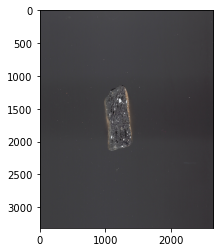

In [80]:
im = plt.imread(f'{alec_path}Ceramic_14.jpeg')
plt.imshow(im)

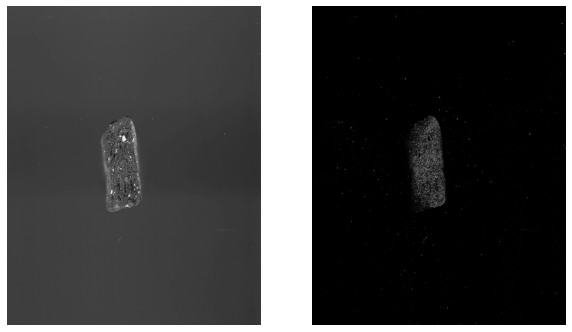

In [81]:
im = rgb2gray(im)
elevation_map = sobel(im)

fig, axes = plt.subplots(ncols =2, figsize = (10,6))

axes[0].imshow(im, cmap = 'gray')
axes[1].imshow(elevation_map, cmap = 'gray')
for ax in axes:
    ax.axis('off')

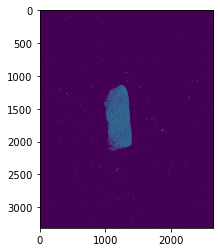

In [82]:
imcan = canny(im)
plt.imshow(imcan)

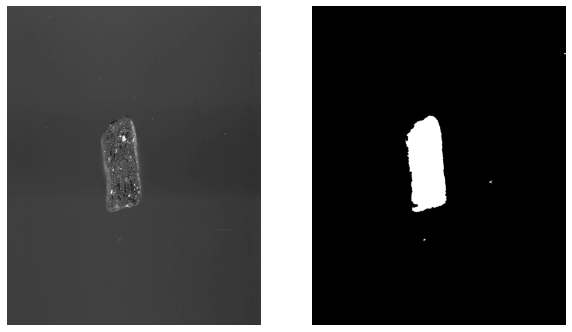

In [83]:
fig, axes = plt.subplots(ncols = 2, figsize = (10,6))
imcan = canny(im)
sherd_bi = remove_small_objects(binary_fill_holes(binary_erosion(binary_dilation(imcan, disk(10)), disk(10))),200)

axes[0].imshow(im, cmap = 'gray')
axes[1].imshow(remove_small_objects(sherd_bi, 200), cmap= 'gray')
for ax in axes:
    ax.axis('off')

In [97]:
im = plt.imread('/Users/aiacobucci922/Documents/CHEM_599/Zorro/Ceramic_1.jpeg')
im_gray = rgb2gray(im)
threshold = threshold_otsu(im_gray)
mask = im_gray > threshold
object_labels = label(mask)
regions = regionprops_table(object_labels, properties = ['area', 'eccentricity', 'major_axis_length', 'orientation'])

In [104]:
testdf = pd.DataFrame(regions)
testdf

,area,eccentricity,major_axis_length,orientation
0,1,0.000000,0.000000,0.785398
1,1,0.000000,0.000000,0.785398
2,1,0.000000,0.000000,0.785398
3,1,0.000000,0.000000,0.785398
4,5,0.854674,4.601429,0.572084
...,...,...,...,...
379,3,0.816497,2.309401,0.785398
380,2,1.000000,2.000000,0.000000
381,266,0.727170,26.030030,-0.192527
382,1,0.000000,0.000000,0.785398


In [109]:
testdf1 = testdf[testdf['area'] > 3]
testdf1

,area,eccentricity,major_axis_length,orientation
4,5,0.854674,4.601429,0.572084
8,27,0.742925,7.320804,0.415792
10,8,0.856535,4.487387,0.994510
11,557152,0.870917,1358.687701,-0.021577
12,4,0.912871,3.464102,-1.249046
...,...,...,...,...
355,7,0.954774,5.744639,1.022076
361,15,0.449243,5.652724,-1.146888
362,13,0.920425,7.249806,1.465844
368,4,0.974669,4.680206,-1.263465


In [129]:
np.sort(testdf1['area'])[-2]

266

In [ ]:
plt.imshow(sherd_bi * im)

In [ ]:
object_labels = label((sherd_bi))
regions = regionprops_table(object_labels, properties = ['area'])
foo = pd.DataFrame(regions)
bar = int(foo.max())
bar

In [ ]:
labeled_sherd = label(sherd_bi)
fig, axes = plt.subplots(ncols = 2, figsize = (10,6))
axes[0].imshow(im, cmap = 'gray')
axes[1].imshow(labeled_sherd, cmap = 'magma')
for ax in axes:
  ax.axis('off')

In [ ]:
markers = np.zeros_like(im)
markers[im < .08] = 1
markers[im > .3] = 2

fig, axes = plt.subplots(ncols = 2, figsize = (10,6))
axes[0].imshow(im, cmap = 'gray')
axes[1].imshow(markers, cmap = 'magma')

In [ ]:
segmentation = watershed(elevation_map, markers= markers)
fig, axes = plt.subplots(ncols = 2, figsize = (10,6))
axes[0].imshow(im, cmap = 'gray')
axes[1].imshow(segmentation, cmap = 'gray')

<ipython-input-84-34e9bee78e55>:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  thresh_val = threshold_otsu(rgb2gray(im))


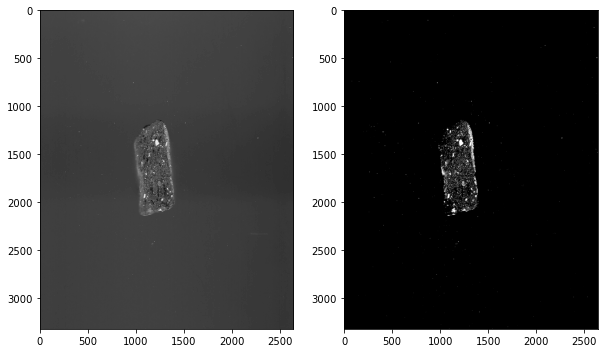

In [84]:
thresh_val = threshold_otsu(rgb2gray(im))
new_mask = im > thresh_val
fig, axes = plt.subplots(ncols = 2, figsize = (10,6))
axes[0].imshow(im, cmap = 'gray')
axes[1].imshow(new_mask, cmap = 'gray')

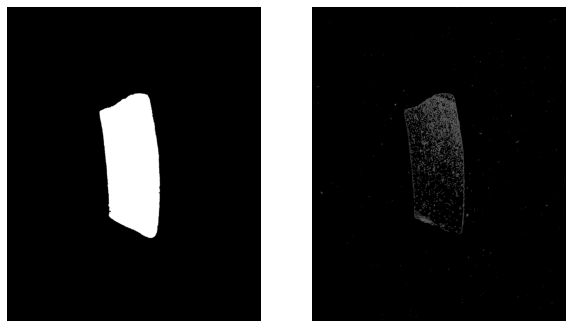

In [76]:
fig, axes = plt.subplots(ncols = 2, figsize = (10,6))
imcan = canny(im)
sherd_bi = remove_small_objects(binary_fill_holes(new_mask, disk(1)), 200)

axes[0].imshow(sherd_bi, cmap = 'gray')
axes[1].imshow(imcan, cmap= 'gray')
for ax in axes:
    ax.axis('off')

In [ ]:
thresh_val = threshold_otsu(rgb2gray(im))
new_mask = im > thresh_val
object_labels = label(new_mask)
regions = regionprops_table(object_labels, properties = ['area'])
foo = pd.DataFrame(regions)
foo

In [ ]:
foo.iloc[0][0]

In [ ]:
plt.imshow(im-new_mask)

In [ ]:

label_img = label(im)
regions = regionprops_table(label_img, properties = ['area'])
pd.DataFrame(regions)